In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import re
import string
import nltk
import spacy
import gensim
from spacy import displacy
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer, PorterStemmer, SnowballStemmer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
%matplotlib inline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer,TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from nltk.probability import FreqDist
from sklearn.svm import LinearSVC
from textblob import TextBlob
from gensim.models import Word2Vec

In [2]:
# Reading data in the system
reviews_df = pd.read_csv('C:\\Ruma\\Datasets\\KaggleDatasets\\amazon_vfl_reviews.csv', encoding="UTF-8")
reviews_df.head()

,asin,name,date,rating,review
0,B07W7CTLD1,Mamaearth-Onion-Growth-Control-Redensyl,2019-09-06,1,I bought this hair oil after viewing so many g...
1,B07W7CTLD1,Mamaearth-Onion-Growth-Control-Redensyl,2019-08-14,5,Used This Mama Earth Newly Launched Onion Oil ...
2,B07W7CTLD1,Mamaearth-Onion-Growth-Control-Redensyl,2019-10-19,1,So bad product...My hair falling increase too ...
3,B07W7CTLD1,Mamaearth-Onion-Growth-Control-Redensyl,2019-09-16,1,Product just smells similar to navarathna hair...
4,B07W7CTLD1,Mamaearth-Onion-Growth-Control-Redensyl,2019-08-18,5,I have been trying different onion oil for my ...


In [3]:
reviews_df.shape

(2782, 5)

In [4]:
# any null columns
reviews_df.isnull().sum()

asin      0
name      0
date      0
rating    0
review    4
dtype: int64

In [5]:
# the review column, four rows without review text, we drop the rows with the null columns
reviews_df = reviews_df.dropna()
#resetting the index
reviews_df = reviews_df.reset_index(drop=True)
# any null columns
reviews_df.isnull().sum()

asin      0
name      0
date      0
rating    0
review    0
dtype: int64

In [6]:
# remove all characters not number or characters
def cleanText(input_string):
    modified_string = re.sub('[^A-Za-z0-9]+', ' ', input_string)
    return(modified_string)
reviews_df['review'] = reviews_df.review.apply(cleanText)
reviews_df['review'][150]

'I am writing this review after using it around 20 days It seems very natural and chemical free and is very gentle on skin But it does its job of cleaning the skin properly It contains tea tree which is one of my favourite ingredients for skin care Give it a try its definitely better than all other chemicals containing face washes And its even affordable as compared to other natural brands available in market '

In [7]:
# From the name we extract the brand
reviews_df['brandName'] = reviews_df['name'].str.split('-').str[0]
reviews_df.head()

,asin,name,date,rating,review,brandName
0,B07W7CTLD1,Mamaearth-Onion-Growth-Control-Redensyl,2019-09-06,1,I bought this hair oil after viewing so many g...,Mamaearth
1,B07W7CTLD1,Mamaearth-Onion-Growth-Control-Redensyl,2019-08-14,5,Used This Mama Earth Newly Launched Onion Oil ...,Mamaearth
2,B07W7CTLD1,Mamaearth-Onion-Growth-Control-Redensyl,2019-10-19,1,So bad product My hair falling increase too mu...,Mamaearth
3,B07W7CTLD1,Mamaearth-Onion-Growth-Control-Redensyl,2019-09-16,1,Product just smells similar to navarathna hair...,Mamaearth
4,B07W7CTLD1,Mamaearth-Onion-Growth-Control-Redensyl,2019-08-18,5,I have been trying different onion oil for my ...,Mamaearth


In [8]:
reviews_df['brandName'].value_counts()

Mamaearth      200
Cinthol        200
Himalaya       200
Titan          200
Godrej         200
Streax         188
Society        182
Tata           180
Dettol         180
Amul           164
Fastrack       160
Mysore         154
Patanjali      152
Britannia      120
MYSORE          40
Reflex          40
Natural         40
Paper           40
PATANJALI       20
Maggi           20
Coca            20
Glucon          20
Savlon          20
Maaza           20
NutriChoice     12
Indiana          6
Name: brandName, dtype: int64

In [9]:
reviews_df['brandName'] = reviews_df['brandName'].str.title()
reviews_df.brandName.unique()

array(['Mamaearth', 'Godrej', 'Titan', 'Maaza', 'Paper', 'Indiana',
       'Coca', 'Natural', 'Maggi', 'Glucon', 'Amul', 'Patanjali',
       'Dettol', 'Savlon', 'Cinthol', 'Britannia', 'Nutrichoice',
       'Streax', 'Himalaya', 'Society', 'Tata', 'Fastrack', 'Reflex',
       'Mysore'], dtype=object)

In [10]:
# Extracting the product from the name column
products = []
for value in reviews_df['name']:
    indx = len(value.split('-')[0])+1
    products.append(value[indx:])
reviews_df['product'] = products
reviews_df['product'].unique()

array(['Onion-Growth-Control-Redensyl',
       'Percent-Natural-Berry-Toothpaste',
       'Natural-Turmeric-Saffron-brightning',
       'Illuminate-Vitamin-Radiant-Turmeric',
       'Blemishes-Pigmentation-Blemish-Mulberry', 'Face-Wash-100-ml',
       'Moisturizing-Baby-Bathing-Oatmeal',
       'Protekt-Master-Blaster-Handwash', 'No-1-Bathing-Soap-Lime',
       'No-1-Bathing-Soap-Turmeric', 'Direct-Cool-Refrigerator-1905-PTDI',
       'aer-Pocket-Bathroom-Fragrance',
       'Security-Solutions-SEEC9060-Electronic',
       'Matic-Spray-Violet-Valley',
       'Security-Solutions-Goldilocks-Personal',
       'ViroShield-Disinfecting-VIROSHIELD-30UV',
       'Analog-Black-Dial-Watch-1805NM01',
       'Analog-White-Dial-Watch-NK1639SL03',
       'Karishma-Analog-Blue-Watch-1774SM01',
       'Karishma-Analog-Black-Watch-NK1639SM02',
       'Octane-Analog-Silver-Watch-NK1650BM03',
       'Analog-Black-Dial-Watch-NK1730SL02',
       'Karishma-Analog-Champagne-Watch-NK1580YL05',
       'Analog-

In [11]:
reviews_df.head()

,asin,name,date,rating,review,brandName,product
0,B07W7CTLD1,Mamaearth-Onion-Growth-Control-Redensyl,2019-09-06,1,I bought this hair oil after viewing so many g...,Mamaearth,Onion-Growth-Control-Redensyl
1,B07W7CTLD1,Mamaearth-Onion-Growth-Control-Redensyl,2019-08-14,5,Used This Mama Earth Newly Launched Onion Oil ...,Mamaearth,Onion-Growth-Control-Redensyl
2,B07W7CTLD1,Mamaearth-Onion-Growth-Control-Redensyl,2019-10-19,1,So bad product My hair falling increase too mu...,Mamaearth,Onion-Growth-Control-Redensyl
3,B07W7CTLD1,Mamaearth-Onion-Growth-Control-Redensyl,2019-09-16,1,Product just smells similar to navarathna hair...,Mamaearth,Onion-Growth-Control-Redensyl
4,B07W7CTLD1,Mamaearth-Onion-Growth-Control-Redensyl,2019-08-18,5,I have been trying different onion oil for my ...,Mamaearth,Onion-Growth-Control-Redensyl


In [99]:
import plotly.graph_objs as go
import chart_studio.plotly as py
import cufflinks
pd.options.display.max_columns = 30
from IPython.core.interactiveshell import InteractiveShell
import plotly.figure_factory as ff
InteractiveShell.ast_node_interactivity = 'all'
from plotly.offline import iplot
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')
reviews_df.groupby(['brandName']).count()['review'].iplot(kind='bar',yTitle='Count',linecolor='black',opacity=0.8,
                                                         title="Brands",xTitle="Brands")

Text analysis with NLTK and Vader Sentiment analyzer

In [12]:
#converting to lower case
reviews_df['clean_review_text']=reviews_df['review'].str.lower()

In [13]:
#removing punctuations
reviews_df['clean_review_text']=reviews_df['clean_review_text'].str.translate(str.maketrans('','',string.punctuation))

In [14]:
stopWords=stopwords.words('english')+['the', 'a', 'an', 'i', 'he', 'she', 'they', 'to', 'of', 'it', 'from']
def removeStopWords(stopWords, rvw_txt):
    newtxt = ' '.join([word for word in rvw_txt.split() if word not in stopWords])
    return newtxt
reviews_df['clean_review_text'] = [removeStopWords(stopWords,x) for x in reviews_df['clean_review_text']]

In [15]:
#splitting text into words
tokenList=[]
for indx in range(len(reviews_df)):
       token=word_tokenize(reviews_df['clean_review_text'][indx])
       tokenList.append(token)
reviews_df['review_tokens'] = tokenList
reviews_df.head()

,asin,name,date,rating,review,brandName,product,clean_review_text,review_tokens
0,B07W7CTLD1,Mamaearth-Onion-Growth-Control-Redensyl,2019-09-06,1,I bought this hair oil after viewing so many g...,Mamaearth,Onion-Growth-Control-Redensyl,bought hair oil viewing many good comments pro...,"[bought, hair, oil, viewing, many, good, comme..."
1,B07W7CTLD1,Mamaearth-Onion-Growth-Control-Redensyl,2019-08-14,5,Used This Mama Earth Newly Launched Onion Oil ...,Mamaearth,Onion-Growth-Control-Redensyl,used mama earth newly launched onion oil twice...,"[used, mama, earth, newly, launched, onion, oi..."
2,B07W7CTLD1,Mamaearth-Onion-Growth-Control-Redensyl,2019-10-19,1,So bad product My hair falling increase too mu...,Mamaearth,Onion-Growth-Control-Redensyl,bad product hair falling increase much order s...,"[bad, product, hair, falling, increase, much, ..."
3,B07W7CTLD1,Mamaearth-Onion-Growth-Control-Redensyl,2019-09-16,1,Product just smells similar to navarathna hair...,Mamaearth,Onion-Growth-Control-Redensyl,product smells similar navarathna hair oil str...,"[product, smells, similar, navarathna, hair, o..."
4,B07W7CTLD1,Mamaearth-Onion-Growth-Control-Redensyl,2019-08-18,5,I have been trying different onion oil for my ...,Mamaearth,Onion-Growth-Control-Redensyl,trying different onion oil hair hair healthy p...,"[trying, different, onion, oil, hair, hair, he..."


In [16]:
nltk.download('vader_lexicon')
sentiment_model = SentimentIntensityAnalyzer()
sentiment_scores=[]
sentiment_score_flag = []
for text in reviews_df['clean_review_text']:
        sentimentResults = sentiment_model.polarity_scores(text)
        sentiment_score = sentimentResults["compound"]
        #print(sentimentResults)
        #The compound value reflects the overall sentiment ranging from -1 being very negative and +1 being very positive.
        sentiment_scores.append(sentiment_score)
        # marking the sentiments as positive, negative and neutral 
        if sentimentResults['compound'] >= 0.05 : 
            sentiment_score_flag.append('positive')
  
        elif sentimentResults['compound'] <= - 0.05 : 
            sentiment_score_flag.append('negative')
  
        else : 
            sentiment_score_flag.append('neutral')
            
reviews_df['scores']=sentiment_scores
reviews_df['scoreStatus'] = sentiment_score_flag

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\sinha\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [17]:
reviews_df.head()

,asin,name,date,rating,review,brandName,product,clean_review_text,review_tokens,scores,scoreStatus
0,B07W7CTLD1,Mamaearth-Onion-Growth-Control-Redensyl,2019-09-06,1,I bought this hair oil after viewing so many g...,Mamaearth,Onion-Growth-Control-Redensyl,bought hair oil viewing many good comments pro...,"[bought, hair, oil, viewing, many, good, comme...",0.7037,positive
1,B07W7CTLD1,Mamaearth-Onion-Growth-Control-Redensyl,2019-08-14,5,Used This Mama Earth Newly Launched Onion Oil ...,Mamaearth,Onion-Growth-Control-Redensyl,used mama earth newly launched onion oil twice...,"[used, mama, earth, newly, launched, onion, oi...",0.8689,positive
2,B07W7CTLD1,Mamaearth-Onion-Growth-Control-Redensyl,2019-10-19,1,So bad product My hair falling increase too mu...,Mamaearth,Onion-Growth-Control-Redensyl,bad product hair falling increase much order s...,"[bad, product, hair, falling, increase, much, ...",-0.6820,negative
3,B07W7CTLD1,Mamaearth-Onion-Growth-Control-Redensyl,2019-09-16,1,Product just smells similar to navarathna hair...,Mamaearth,Onion-Growth-Control-Redensyl,product smells similar navarathna hair oil str...,"[product, smells, similar, navarathna, hair, o...",-0.2732,negative
4,B07W7CTLD1,Mamaearth-Onion-Growth-Control-Redensyl,2019-08-18,5,I have been trying different onion oil for my ...,Mamaearth,Onion-Growth-Control-Redensyl,trying different onion oil hair hair healthy p...,"[trying, different, onion, oil, hair, hair, he...",0.9286,positive


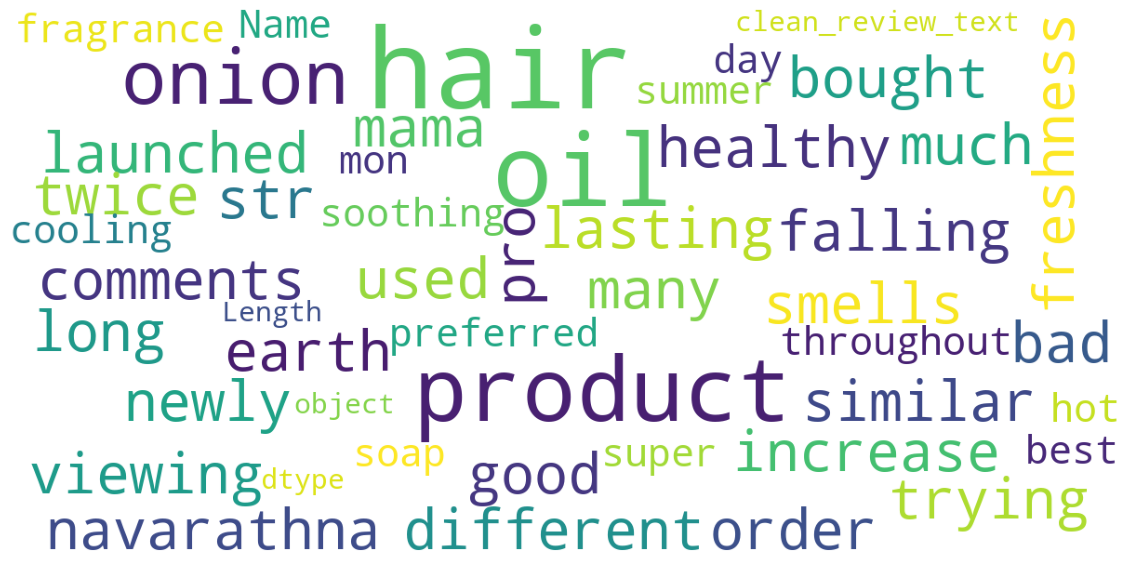

In [18]:
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()
    
# print wordcloud
show_wordcloud(reviews_df["clean_review_text"])

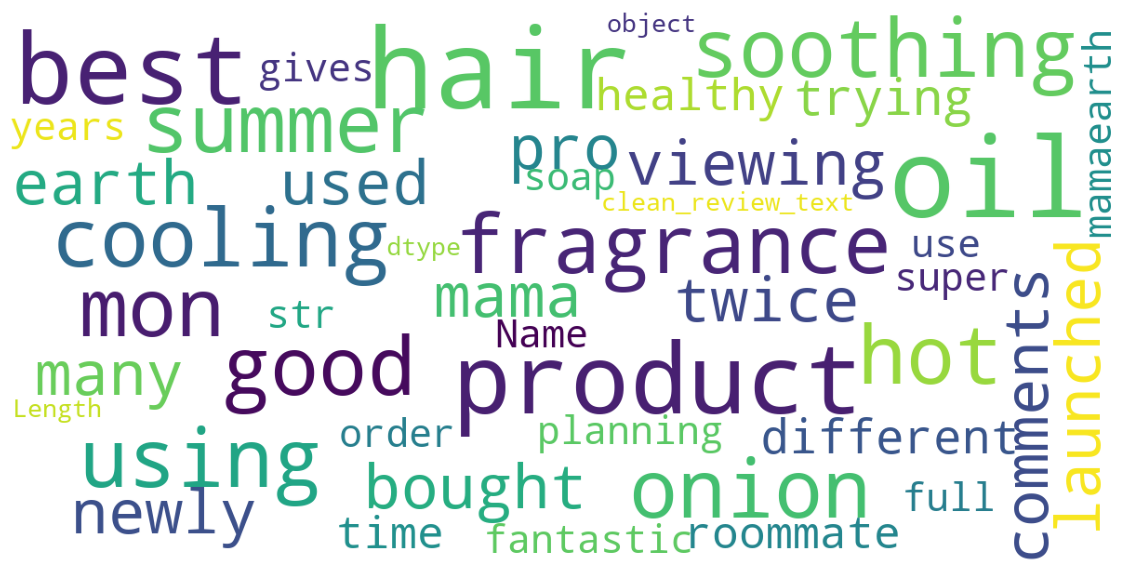

In [19]:
# print wordcloud
positiveReviews_df =reviews_df.loc[reviews_df['scoreStatus'] == "positive"]
show_wordcloud(positiveReviews_df["clean_review_text"])

In [104]:
positiveReviews_df.groupby(['brandName']).count()['scoreStatus'].iplot(kind='bar',yTitle='Count',linecolor='black',opacity=0.8,
                                                         title="Brands",xTitle="Brands")

In [127]:
a = pd.DataFrame(positiveReviews_df.groupby(['brandName']).count()["clean_review_text"])
positiveReviews_df.loc[positiveReviews_df['brandName'] == "Indiana"]["review"]

640    It comes with a delicious taste you can consum...
641    It s a vegetarian products we can also consume...
642    Very good buy of a very good product Best toot...
643    It comes with a delicious taste you can consum...
644    It s a vegetarian products we can also consume...
645    Very good buy of a very good product Best toot...
Name: review, dtype: object

In [120]:
b = pd.DataFrame(negativeReviews_df.groupby(['brandName']).count()["clean_review_text"])

In [122]:
c = pd.concat([a, b], axis=1)
c.columns = ['positiveReviews','negativeReviews']
c

,positiveReviews,negativeReviews
Amul,134,12.0
Britannia,90,18.0
Cinthol,170,20.0
Coca,16,4.0
Dettol,142,22.0
Fastrack,140,16.0
Glucon,14,2.0
Godrej,150,48.0
Himalaya,158,38.0
Indiana,6,NaN


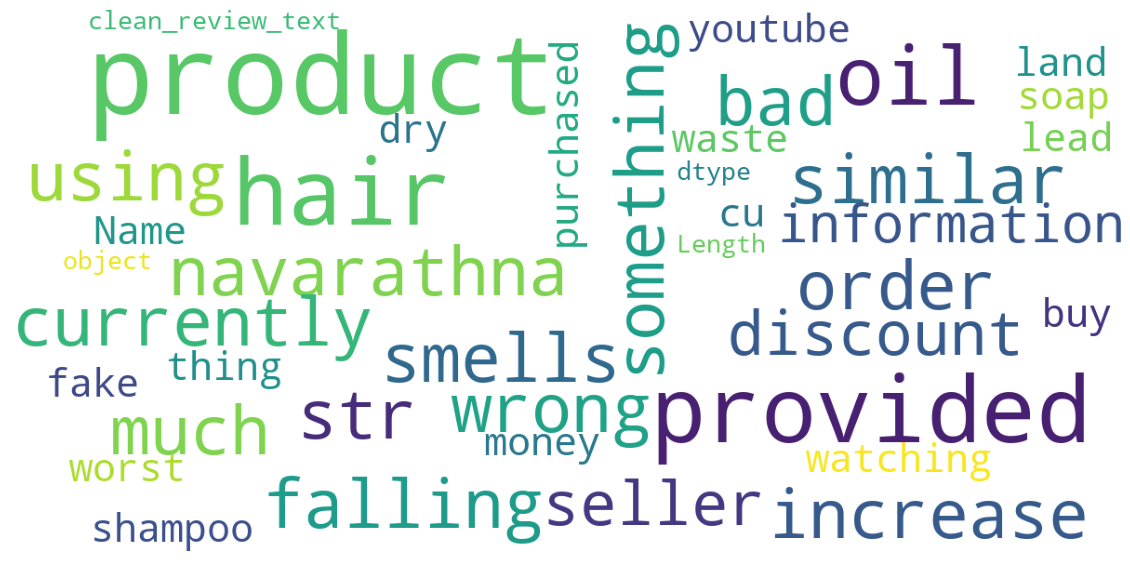

In [20]:
## print wordcloud
negativeReviews_df =reviews_df.loc[reviews_df['scoreStatus'] == "negative"]
show_wordcloud(negativeReviews_df["clean_review_text"])

In [105]:
negativeReviews_df.groupby(['brandName']).count()['scoreStatus'].iplot(kind='bar',yTitle='Count',linecolor='black',opacity=0.8,
                                                         title="Brands",xTitle="Brands")

In [21]:
features = CountVectorizer()
features.fit(reviews_df["clean_review_text"])
print(len(features.vocabulary_))
print(features.vocabulary_)

4687
{'bought': 615, 'hair': 1916, 'oil': 2879, 'viewing': 4476, 'many': 2541, 'good': 1842, 'comments': 917, 'product': 3235, 'enough': 1454, 'first': 1645, 'expensive': 1521, 'second': 3650, 'thing': 4207, 'amount': 322, 'low': 2479, 'half': 1925, 'bottle': 611, 'yes': 4671, 'completely': 946, 'filled': 1628, 'cheating': 805, 'customers': 1097, 'mamaearth': 2526, 'trust': 4335, 'fool': 1690, 'people': 3044, 'know': 2302, 'brand': 626, 'going': 1837, 'buy': 698, 'thumbs': 4235, 'onion': 2898, 'used': 4421, 'mama': 2525, 'earth': 1391, 'newly': 2783, 'launched': 2338, 'twice': 4352, 'must': 2747, 'say': 3612, 'im': 2100, 'already': 301, 'impressed': 2111, 'results': 3513, 'prevents': 3202, 'loss': 2461, 'helps': 1991, 'control': 1009, 'premature': 3181, 'greying': 1883, 'dryness': 1368, 'dandruff': 1122, 'scalp': 3616, 'eruptions': 1472, 'problems': 3227, 'regular': 3432, 'use': 4420, 'avoid': 440, 'dry': 1366, 'frizzy': 1749, 'make': 2514, 'sure': 4074, 'hairs': 1922, 'week': 4559, 'o

In [22]:
bagofWords = features.transform(reviews_df["clean_review_text"])
print(bagofWords)

  (0, 322)	1
  (0, 611)	2
  (0, 615)	1
  (0, 626)	2
  (0, 698)	1
  (0, 805)	1
  (0, 917)	1
  (0, 946)	1
  (0, 1097)	1
  (0, 1454)	2
  (0, 1521)	1
  (0, 1628)	1
  (0, 1645)	1
  (0, 1690)	1
  (0, 1837)	1
  (0, 1842)	3
  (0, 1916)	1
  (0, 1925)	1
  (0, 2302)	1
  (0, 2479)	1
  (0, 2526)	2
  (0, 2541)	1
  (0, 2879)	3
  (0, 2898)	1
  (0, 3044)	1
  :	:
  (2772, 1586)	1
  (2773, 1135)	1
  (2773, 1742)	1
  (2773, 2327)	1
  (2773, 2442)	1
  (2773, 4227)	1
  (2774, 3180)	1
  (2774, 3835)	1
  (2776, 3235)	1
  (2776, 4055)	1
  (2777, 536)	1
  (2777, 1023)	1
  (2777, 1178)	1
  (2777, 1366)	1
  (2777, 1720)	1
  (2777, 2052)	2
  (2777, 2068)	1
  (2777, 2091)	1
  (2777, 2360)	1
  (2777, 2708)	2
  (2777, 3438)	1
  (2777, 3798)	1
  (2777, 3835)	1
  (2777, 3874)	1
  (2777, 4048)	2


In [23]:
print(bagofWords.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [24]:
print(features.get_feature_names())

['00', '01', '02', '03', '06', '07', '08', '09', '10', '100', '1000', '100grm', '100ml', '1020rs', '1025rs', '109', '10calories', '10days', '10ltrs', '10thickness', '11', '110', '119', '12', '120', '120rs', '1234', '125', '1256', '125g', '127rs', '13', '130', '1300', '14', '140', '140rs', '1499', '15', '1500', '1500ml', '150gm', '150gms', '151', '153', '15th', '16', '160', '165', '165rs', '168', '16k', '170', '171310', '173', '175rs', '18', '182', '185', '188rs', '18best', '18exp', '18i', '18made', '19', '190', '195', '199', '1995', '1kg', '1month', '1st', '1time', '1whole', '1yr', '20', '200', '20000', '200g', '200it', '200ml', '2015', '2016', '2017', '2018', '2019', '2020', '2022', '21', '210', '216', '21600', '22', '220', '23', '230', '2395', '23march', '24', '24x7', '25', '250', '2500rs', '26july', '27', '28', '29th', '2k', '2months', '2nd', '2pcs', '2weeks', '2years', '30', '300', '3000', '30days', '30ml', '31', '310', '315', '320', '325', '347', '355', '365', '385', '3daz', '3rd'

In [25]:
df = pd.concat([positiveReviews_df,negativeReviews_df])
df = df[["clean_review_text","scoreStatus"]]
df['scoreStatus'] = (df['scoreStatus'] == 'positive')*1
X = df["clean_review_text"]
y = df["scoreStatus"]
X_train, X_test, y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=0)

In [26]:
X_train = features.fit_transform(X_train)
X_test = features.transform(X_test)

In [27]:
#k fold cross validation with k=5
scores = cross_val_score(LogisticRegression(),X_train,y_train,cv=5)
print(np.mean(scores))

0.9536312849162012


In [28]:
model=LogisticRegression()
model.fit(X_train,y_train)
print(model.score(X_train,y_train))
print(model.score(X_test,y_test))

0.9972067039106145
0.9700520833333334


In [29]:
y_pred = model.predict(X_test)
confusion_matrix(y_test,y_pred)

array([[101,  23],
       [  0, 644]], dtype=int64)

In [30]:
text = "the product great"
model.predict(features.transform([text]))[0]

1

In [31]:
text = "bad"
model.predict(features.transform([text]))[0]

0

In [32]:
text = "sucks"
model.predict(features.transform([text]))[0]

1

In [33]:
text = "very bad"
model.predict(features.transform([text]))[0]

0

In [34]:
text = "not good"
model.predict(features.transform([text]))[0]

1

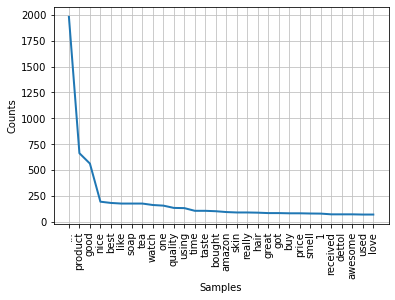

In [35]:
tokenized_word=word_tokenize((reviews_df['clean_review_text'].to_string()))
#Frequency Distribution
fdist = FreqDist(tokenized_word)
# Frequency Distribution Plot
fdist.plot(30,cumulative=False)
plt.show()

Text Analytics with spacy

In [36]:
nlp=spacy.load("en_core_web_sm")

In [71]:
text = reviews_df['review'][1130]
doc=nlp(text)
type(doc)
print(doc)

There are plenty of other brands which are similar to Dettol but the question is whether you can trust it or not In my home the product is used as mixture with water for rinsing clothes mopping floor and as spray liquid to disinfect It is a also a part of the first aid box The fresh lime fragrance smells great 


In [72]:
#Tokens
for token in doc:
    print(token.text)

There
are
plenty
of
other
brands
which
are
similar
to
Dettol
but
the
question
is
whether
you
can
trust
it
or
not
In
my
home
the
product
is
used
as
mixture
with
water
for
rinsing
clothes
mopping
floor
and
as
spray
liquid
to
disinfect
It
is
a
also
a
part
of
the
first
aid
box
The
fresh
lime
fragrance
smells
great


In [73]:
#Stopwords
stopwords=spacy.lang.en.stop_words.STOP_WORDS
stopWords = list(stopwords)
len(stopWords)

326

In [74]:
for token in doc:
    if token.is_stop == False:
        print(token)

plenty
brands
similar
Dettol
question
trust
home
product
mixture
water
rinsing
clothes
mopping
floor
spray
liquid
disinfect
aid
box
fresh
lime
fragrance
smells
great


In [75]:
print(len(doc))
doc2=[]
for token in doc:
    if not token.is_stop:
        doc2.append(token)
print(len(doc2))

61
24


In [76]:
#lemmatization
for review_text in doc:
    print(review_text.text,review_text.lemma_)

There there
are be
plenty plenty
of of
other other
brands brand
which which
are be
similar similar
to to
Dettol Dettol
but but
the the
question question
is be
whether whether
you -PRON-
can can
trust trust
it -PRON-
or or
not not
In in
my -PRON-
home home
the the
product product
is be
used use
as as
mixture mixture
with with
water water
for for
rinsing rinse
clothes clothe
mopping mop
floor floor
and and
as as
spray spray
liquid liquid
to to
disinfect disinfect
It -PRON-
is be
a a
also also
a a
part part
of of
the the
first first
aid aid
box box
The the
fresh fresh
lime lime
fragrance fragrance
smells smell
great great


In [77]:
#POS
for token in doc:
   print(token,token.tag_,token.pos_,spacy.explain(token.tag_))

There EX PRON existential there
are VBP AUX verb, non-3rd person singular present
plenty NN NOUN noun, singular or mass
of IN ADP conjunction, subordinating or preposition
other JJ ADJ adjective
brands NNS NOUN noun, plural
which WDT DET wh-determiner
are VBP AUX verb, non-3rd person singular present
similar JJ ADJ adjective
to IN ADP conjunction, subordinating or preposition
Dettol NNP PROPN noun, proper singular
but CC CCONJ conjunction, coordinating
the DT DET determiner
question NN NOUN noun, singular or mass
is VBZ AUX verb, 3rd person singular present
whether IN SCONJ conjunction, subordinating or preposition
you PRP PRON pronoun, personal
can MD VERB verb, modal auxiliary
trust VB VERB verb, base form
it PRP PRON pronoun, personal
or CC CCONJ conjunction, coordinating
not RB PART adverb
In IN ADP conjunction, subordinating or preposition
my PRP$ DET pronoun, possessive
home NN NOUN noun, singular or mass
the DT DET determiner
product NN NOUN noun, singular or mass
is VBZ AUX ver

In [78]:
displacy.render(doc,style='dep',jupyter=True,options={'distance':90})

In [79]:
for entity in doc.ents:
    print(entity.text,'---->',entity.label_)
displacy.render(doc,style='ent',jupyter=True)

Dettol ----> ORG
first ----> ORDINAL


In [46]:
#word vectors and similarity
#large pre trained model
!python -m spacy download en_core_web_lg

[+] Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [47]:
import en_core_web_lg
nlp = en_core_web_lg.load()
doc=nlp(text)
for token in doc:
    print(token.text,'---->',token.has_vector)

I ----> True
have ----> True
oily ----> True
acne ----> True
prone ----> True
skin ----> True
and ----> True
have ----> True
been ----> True
using ----> True
this ----> True
product ----> True
for ----> True
a ----> True
few ----> True
days ----> True
now ----> True
My ----> True
acne ----> True
has ----> True
dried ----> True
out ----> True
but ----> True
I ----> True
do ----> True
not ----> True
see ----> True
a ----> True
significant ----> True
improvement ----> True
in ----> True
dark ----> True
spots ----> True
yet ----> True
The ----> True
fragrance ----> True
is ----> True
mild ----> True
so ----> True
brilliant ----> True
I ----> True
ll ----> True
continue ----> True
using ----> True
this ----> True
as ----> True
it ----> True
helped ----> True
my ----> True
acne ----> True
Just ----> True
a ----> True
tip ----> True
to ----> True
all ----> True
people ----> True
with ----> True
acne ----> True
skin ----> True
Keep ----> True
your ----> True
scalp ----> True
clean ----> True
a

In [48]:
for token in doc:
    print(token.text,'',token.vector_norm)

I  6.4231944
have  5.036123
oily  7.2433777
acne  8.455896
prone  5.8086314
skin  7.6824646
and  4.6577983
have  5.036123
been  5.2458506
using  5.685473
this  5.0461264
product  6.1002045
for  4.8435082
a  5.306696
few  5.220241
days  5.989626
now  4.8410244
My  5.837562
acne  8.455896
has  5.028274
dried  7.334754
out  4.7105656
but  4.903002
I  6.4231944
do  5.6477365
not  4.9436083
see  4.8916583
a  5.306696
significant  5.5786905
improvement  5.8007097
in  5.0929856
dark  6.54064
spots  5.999102
yet  4.924492
The  4.70935
fragrance  7.8078847
is  4.890306
mild  6.9817843
so  5.0674334
brilliant  5.853958
I  6.4231944
ll  5.4786563
continue  5.3828826
using  5.685473
this  5.0461264
as  4.5106106
it  4.9409766
helped  5.4338746
my  5.837562
acne  8.455896
Just  4.9510865
a  5.306696
tip  5.8265495
to  4.74484
all  4.932093
people  5.853792
with  4.7708583
acne  8.455896
skin  7.6824646
Keep  5.345807
your  6.04087
scalp  7.5521746
clean  6.4559617
and  4.6577983
change  5.3572474
y

In [49]:
#similarity score
text="eat"
text1="ate"
doc=nlp(text)
doc1=nlp(text1)
doc.similarity(doc1)

0.7747560894031831

In [50]:
#similarity score
text="good"
text1="bad"
doc=nlp(text)
doc1=nlp(text1)
doc.similarity(doc1)

0.7355090324289566

In [51]:
#similarity score
text="hot"
text1="summer"
doc=nlp(text)
doc1=nlp(text1)
doc.similarity(doc1)

0.4288859559801436

In [52]:
#similarity score
text="excellent"
text1="good"
doc=nlp(text)
doc1=nlp(text1)
doc.similarity(doc1)

0.7774078298027361

In [53]:
#similarity score
text="sucks"
text1="bad"
doc=nlp(text)
doc1=nlp(text1)
doc.similarity(doc1)

0.5329751363061155

In [54]:
df = pd.concat([positiveReviews_df,negativeReviews_df])
df = df[["clean_review_text","scoreStatus"]]
df['scoreStatus'] = (df['scoreStatus'] == 'positive')*1

In [55]:
#Tokenization
punct = string.punctuation
print(punct)
def cleanText(sent):
    doc = nlp(sent)
    tokens = []
    for token in doc:
        if token.lemma != "-PRON-":
            tokens.append(token.lemma_.lower().strip())
        else:
            tokens.append(token.lemma_)
            
    cleanTokens = []
    for token in tokens:
        if token not in stopWords and token not in punct:
            cleanTokens.append(token)
    return cleanTokens

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [56]:
#TFIDF
tfidf = TfidfVectorizer(tokenizer = cleanText)
classifier = LinearSVC()
X = df["clean_review_text"]
y = df["scoreStatus"]
X_train, X_test, y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=0)

In [57]:
X_train.shape, X_test.shape

((1790,), (768,))

In [58]:
clf = Pipeline([('tfidf',tfidf),('clf',classifier)])
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

In [59]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      0.89      0.94       124
           1       0.98      1.00      0.99       644

    accuracy                           0.98       768
   macro avg       0.99      0.94      0.96       768
weighted avg       0.98      0.98      0.98       768



In [60]:
confusion_matrix(y_test,y_pred)

array([[110,  14],
       [  0, 644]], dtype=int64)

With TextBlob

In [102]:
nltk.download('averaged_perceptron_tagger')
blob = TextBlob(str(reviews_df['review']))
pos_df = pd.DataFrame(blob.tags, columns = ['word' , 'pos'])
pos_df = pos_df.pos.value_counts()[:20]
pos_df.iplot(
    kind='bar',
    xTitle='POS',
    yTitle='count', 
    title='Top 20 Part-of-speech tagging for review corpus')


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\sinha\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.


True

In [61]:
pol = lambda x: TextBlob(x).sentiment.polarity
sub = lambda x: TextBlob(x).sentiment.subjectivity
reviews_df["polarity"] = reviews_df["review"].apply(pol)
reviews_df["subjectivity"] = reviews_df["review"].apply(sub)

<AxesSubplot:xlabel='rating', ylabel='count'>

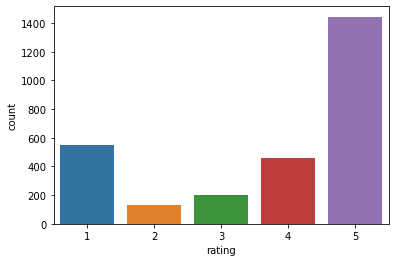

In [62]:
#distribution of rating
sns.countplot(x='rating', data=reviews_df)

In [63]:
reviews_df.head()

,asin,name,date,rating,review,brandName,product,clean_review_text,review_tokens,scores,scoreStatus,polarity,subjectivity
0,B07W7CTLD1,Mamaearth-Onion-Growth-Control-Redensyl,2019-09-06,1,I bought this hair oil after viewing so many g...,Mamaearth,Onion-Growth-Control-Redensyl,bought hair oil viewing many good comments pro...,"[bought, hair, oil, viewing, many, good, comme...",0.7037,positive,0.016270,0.463492
1,B07W7CTLD1,Mamaearth-Onion-Growth-Control-Redensyl,2019-08-14,5,Used This Mama Earth Newly Launched Onion Oil ...,Mamaearth,Onion-Growth-Control-Redensyl,used mama earth newly launched onion oil twice...,"[used, mama, earth, newly, launched, onion, oi...",0.8689,positive,0.327189,0.499484
2,B07W7CTLD1,Mamaearth-Onion-Growth-Control-Redensyl,2019-10-19,1,So bad product My hair falling increase too mu...,Mamaearth,Onion-Growth-Control-Redensyl,bad product hair falling increase much order s...,"[bad, product, hair, falling, increase, much, ...",-0.6820,negative,-0.400000,0.511111
3,B07W7CTLD1,Mamaearth-Onion-Growth-Control-Redensyl,2019-09-16,1,Product just smells similar to navarathna hair...,Mamaearth,Onion-Growth-Control-Redensyl,product smells similar navarathna hair oil str...,"[product, smells, similar, navarathna, hair, o...",-0.2732,negative,0.010417,0.547917
4,B07W7CTLD1,Mamaearth-Onion-Growth-Control-Redensyl,2019-08-18,5,I have been trying different onion oil for my ...,Mamaearth,Onion-Growth-Control-Redensyl,trying different onion oil hair hair healthy p...,"[trying, different, onion, oil, hair, hair, he...",0.9286,positive,0.286813,0.626374


In [64]:
print("negative reviews")
most_negative = reviews_df[reviews_df.polarity == -1].review.head()
print(most_negative)
print("positive reviews")
most_positive = reviews_df[reviews_df.polarity == 1].review.head()
print(most_positive)

negative reviews
346     Worst product Product is not working after 10d...
356     Worst product Product is not working after 10d...
1566                                   taste is terrible 
1572                                   taste is terrible 
Name: review, dtype: object
positive reviews
384                 Best Product in these price segment 
394                 Best Product in these price segment 
402    After 1 week of use Seems perfect 10 10 for lo...
407                                       Simply awesome
412    After 1 week of use Seems perfect 10 10 for lo...
Name: review, dtype: object


Text analysis with gensim and word2vec

In [82]:
sentences = reviews_df['review_tokens'][10:20]
sentences

10    [bought, hair, oil, viewing, many, good, comme...
11    [used, mama, earth, newly, launched, onion, oi...
12    [bad, product, hair, falling, increase, much, ...
13    [product, smells, similar, navarathna, hair, o...
14    [trying, different, onion, oil, hair, hair, he...
15    [using, product, time, roommate, planning, ord...
16    [purchased, oil, shampoo, watching, fake, yout...
17    [good, product, mamaearth, oil, gives, hair, f...
18    [showing, onion, oil, benefits, ad, ate, givin...
19    [used, one, time, say, hairfall, control, stop...
Name: review_tokens, dtype: object

In [83]:
#train model
model = Word2Vec(sentences, min_count=1)
print(model)

Word2Vec(vocab=251, size=100, alpha=0.025)


In [84]:
#vocab
words=list(model.wv.vocab)
print(words)

['bought', 'hair', 'oil', 'viewing', 'many', 'good', 'comments', 'product', 'enough', 'first', 'expensive', 'second', 'thing', 'amount', 'low', 'half', 'bottle', 'yes', 'completely', 'filled', 'cheating', 'customers', 'mamaearth', 'trust', 'fool', 'people', 'know', 'brand', 'going', 'buy', 'thumbs', 'onion', 'used', 'mama', 'earth', 'newly', 'launched', 'twice', 'must', 'say', 'im', 'already', 'impressed', 'results', 'prevents', 'loss', 'helps', 'control', 'premature', 'greying', 'dryness', 'dandruff', 'scalp', 'eruptions', 'problems', 'regular', 'use', 'avoid', 'dry', 'frizzy', 'make', 'sure', 'hairs', 'week', 'oiling', 'provides', 'essential', 'nutrients', 'also', 'strengthens', 'roots', 'works', 'best', 'seasons', 'bad', 'falling', 'increase', 'much', 'order', 'shampoo', 'mask', 'nothing', 'stop', 'hairfallafter', '3', '4', 'wash', 'badly', 'smells', 'similar', 'navarathna', 'strong', 'sticky', 'applying', 'three', 'drops', 'review', 'usage', '2', 'months1', 'worst', 'product2', 'fa

In [85]:
#nltk.download('punkt')
reviewsText = reviews_df.clean_review_text.values
reviewsVec = [nltk.word_tokenize(review) for review in reviewsText]
len(reviewsVec)

2778

In [86]:
model = Word2Vec(reviewsVec,min_count=1, size=32)
model.most_similar('soothing')

[('50', 0.9992689490318298),
 ('fresh', 0.9991564154624939),
 ('also', 0.9991469383239746),
 ('looking', 0.9991449117660522),
 ('looks', 0.9991247057914734),
 ('soap', 0.9991230964660645),
 ('sure', 0.9991198778152466),
 ('bath', 0.9991174340248108),
 ('still', 0.9990980625152588),
 ('package', 0.9990959167480469)]

In [70]:
model = Word2Vec(reviewsVec,min_count=1, size=32)
model.most_similar('packaging')

[('good', 0.9997533559799194),
 ('product', 0.999735951423645),
 ('delivered', 0.9997122287750244),
 ('delivery', 0.999708890914917),
 ('definitely', 0.9996815919876099),
 ('4', 0.9996811151504517),
 ('thanks', 0.9996523261070251),
 ('think', 0.9996428489685059),
 ('amazon', 0.9996273517608643),
 ('packet', 0.9996271133422852)]